<a href="https://colab.research.google.com/github/Dok31/neural-networks-hw/blob/main/Adwert_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo

In [ ]:
!pip install cleverhans

In [ ]:

from torchinfo import summary
import torchvision.models as models
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
import numpy as np
from torch.autograd import Variable  # для автоматического дифференцирования

In [ ]:
# model = models.resnet50(pretrained=True) # загружаем готовую модель
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
model.eval()
summary(model, (1, 3, 224, 224))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-5                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 128, 56, 56]          --
│    └─Conv2d: 2-7                       [1, 256, 56, 56]          295,168
│    └─ReLU: 2-8                         [1, 256, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          590,080
│    └─ReLU: 2-10                        [1, 256, 56, 56]          --
│    └─MaxPool2d: 2-11                   [1, 256, 28, 28]          -

In [ ]:
# Названия классов
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-03-13 12:47:24--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-03-13 12:47:24 (74.5 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



In [ ]:
# прочитаем
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
# ссылки, на которых лежат нужные нам изображения
urls = ['https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Pearl_Winter_White_Russian_Dwarf_Hamster_-_Front.jpg/1920px-Pearl_Winter_White_Russian_Dwarf_Hamster_-_Front.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Rooster02.jpg/330px-Rooster02.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/e/ed/Cape_dwarf_chameleon_%28Bradypodion_pumilum%29_male.jpg',
        'https://exotickozha.ru/userfiles/dtghrtfg.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/b/bf/Bucephala-albeola-010.jpg']
filenames = ['hamster.jpg', 'cock.jpg', 'chameleon.jpg', 'alligator.jpg', 'duck.jpg']

Я выбрала следующие классы:
hamster, cock, African chameleon, American alligator, red-breasted merganser(утка)



In [ ]:
# Скачиваем изображения
import urllib

url, filename = ('https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Pearl_Winter_White_Russian_Dwarf_Hamster_-_Front.jpg/1920px-Pearl_Winter_White_Russian_Dwarf_Hamster_-_Front.jpg', 'hamster.jpg')
for url, filename in zip(urls, filenames):
    try: urllib.URLopener().retrieve(url, filename)
    except: urllib.request.urlretrieve(url, filename)

In [ ]:
# Предобработка изображения
from PIL import Image
from torchvision import transforms
# масштабируем и нормализуем
preprocess = transforms.Compose([
    transforms.Resize(256), # масштабируем
    transforms.CenterCrop(224), # обрезаем
    transforms.ToTensor(), # в тип Тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # нормализуем
])
# потом понадобится обратно денормализовать
postprocess = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

# предобоработаем картинки для передачи на вход нейросети
images = []
input_tensors = []
input_batches = []

for i in filenames:
    images.append(Image.open(i))
    input_tensors.append(preprocess(images[-1]))
    input_batches.append(input_tensors[-1].unsqueeze(0))


In [ ]:
# если есть GPU то на переводим модель на нее
if torch.cuda.is_available():
    for i in range(len(input_batches)):
        input_batches[i] = input_batches[i].to('cuda')
    model.to('cuda')
# запускаем модель
outputs = []
with torch.no_grad():
    for i in input_batches:
        outputs.append(model(i))
# возвращается вектор из 1000 элементов для классов Imagenet

# но они не нормализованы, нормализуем с помощью softmax
probabilities = []
for i in outputs:
    probabilities.append(torch.nn.functional.softmax(i[0], dim=0))


In [ ]:
# выберем самые уверенно распознанные классы
top_probs = []
top_catids = []
for i in probabilities:
    top_prob, top_catid = torch.topk(i, 1)
    top_probs.append(top_prob)
    top_catids.append(top_catid)

for i in range(len(top_probs)):
    print(categories[top_catids[i]], top_probs[i].item(), f'(номер класа {int(top_catids[i])})')

hamster 0.992431640625 (номер класа 333)
cock 0.6830553412437439 (номер класа 7)
African chameleon 0.9982730150222778 (номер класа 47)
American alligator 0.7021894454956055 (номер класа 50)
red-breasted merganser 0.8725959658622742 (номер класа 98)


In [ ]:
for i in images:
    display(i)

In [ ]:
NUM_STEPS=250 # число шагов атаки
EPSILON=1e-3# "сила" атаки
targeted=True # направленная
goals=[333, 7, 47, 50, 98] # цели (номера классов) атаки
BATCH_SIZE=1


In [ ]:
for i in range(len(input_batches)):
    input_batches[i] = Variable(input_batches[i])
    if torch.cuda.is_available(): # на граф. ускоритель, если есть
        input_batches[i] = input_batches[i].cuda()



In [ ]:
from tqdm import tqdm
attack_images = [[] for i in range(len(input_batches))]
for i in tqdm(range(len(input_batches))):
    xs = input_batches[i]
    for goal in goals:

        target=goal*np.ones(shape=[BATCH_SIZE]).astype('long')
        target=torch.tensor(target,dtype=torch.long)# переводим в тензор torch
        # Атакующее изображение
        xs_adw=xs # берем исходное изображение
        if torch.cuda.is_available(): # цели тоже должны быть на GPU
            target = target.cuda()
        for j in range(0,NUM_STEPS): # и несколько раз подряд атакуем (изменяем) его
            xs_adw = fast_gradient_method(model, # модель атакуемой нейроной сети
                                        xs_adw, # исходное изображение
                                        eps=EPSILON, # сила атаки
                                        norm=np.inf, # параметр метода, не изменяем
                                        #clip_min=0., # обрезка значений снизу
                                        #clip_max=1., # обрезка значений сверху
                                        targeted=True, # направленная атака
                                        y=target # цель атаки
                                        )
        attack_images[i].append(xs_adw)



100%|██████████| 5/5 [02:27<00:00, 29.51s/it]


In [ ]:
model_outputs_after_attack = [[] for i in range(len(attack_images))]

for i in range(len(filenames)):
    orig_class = filenames[i].split('.')[0]
    print(orig_class)
    for j in range(len(attack_images[i])):
        preds_adw = model(attack_images[i][j]) # рассчитываем выход для атакованного изображения
        preds_adw = preds_adw.cpu().detach() # на CPU
        preds_adw = torch.nn.functional.softmax(preds_adw[0], dim=0) # нормализуем
        pred_adw_prob, pred_adw_catid = torch.topk(preds_adw, 1) #  самый уверенный класс

        print(f'Class #{pred_adw_catid.item()} ={categories[pred_adw_catid]} Prob={pred_adw_prob.item()}')
        model_outputs_after_attack[i].append(f'{categories[pred_adw_catid]} Prob={round(pred_adw_prob.item(), 5)}')


hamster
Class #333 =hamster Prob=0.9999998807907104
Class #7 =cock Prob=1.0
Class #47 =African chameleon Prob=0.9999998807907104
Class #50 =American alligator Prob=0.9999998807907104
Class #98 =red-breasted merganser Prob=0.9999997615814209
cock
Class #333 =hamster Prob=0.9999997615814209
Class #7 =cock Prob=0.9999996423721313
Class #47 =African chameleon Prob=0.9999998807907104
Class #50 =American alligator Prob=1.0
Class #98 =red-breasted merganser Prob=1.0
chameleon
Class #333 =hamster Prob=0.9999997615814209
Class #7 =cock Prob=0.9999997615814209
Class #47 =African chameleon Prob=1.0
Class #50 =American alligator Prob=0.9999998807907104
Class #98 =red-breasted merganser Prob=1.0
alligator
Class #333 =hamster Prob=1.0
Class #7 =cock Prob=0.9999998807907104
Class #47 =African chameleon Prob=0.9999998807907104
Class #50 =American alligator Prob=0.9999997615814209
Class #98 =red-breasted merganser Prob=1.0
duck
Class #333 =hamster Prob=1.0
Class #7 =cock Prob=0.9999998807907104
Class #

<Figure size 1000x1000 with 0 Axes>

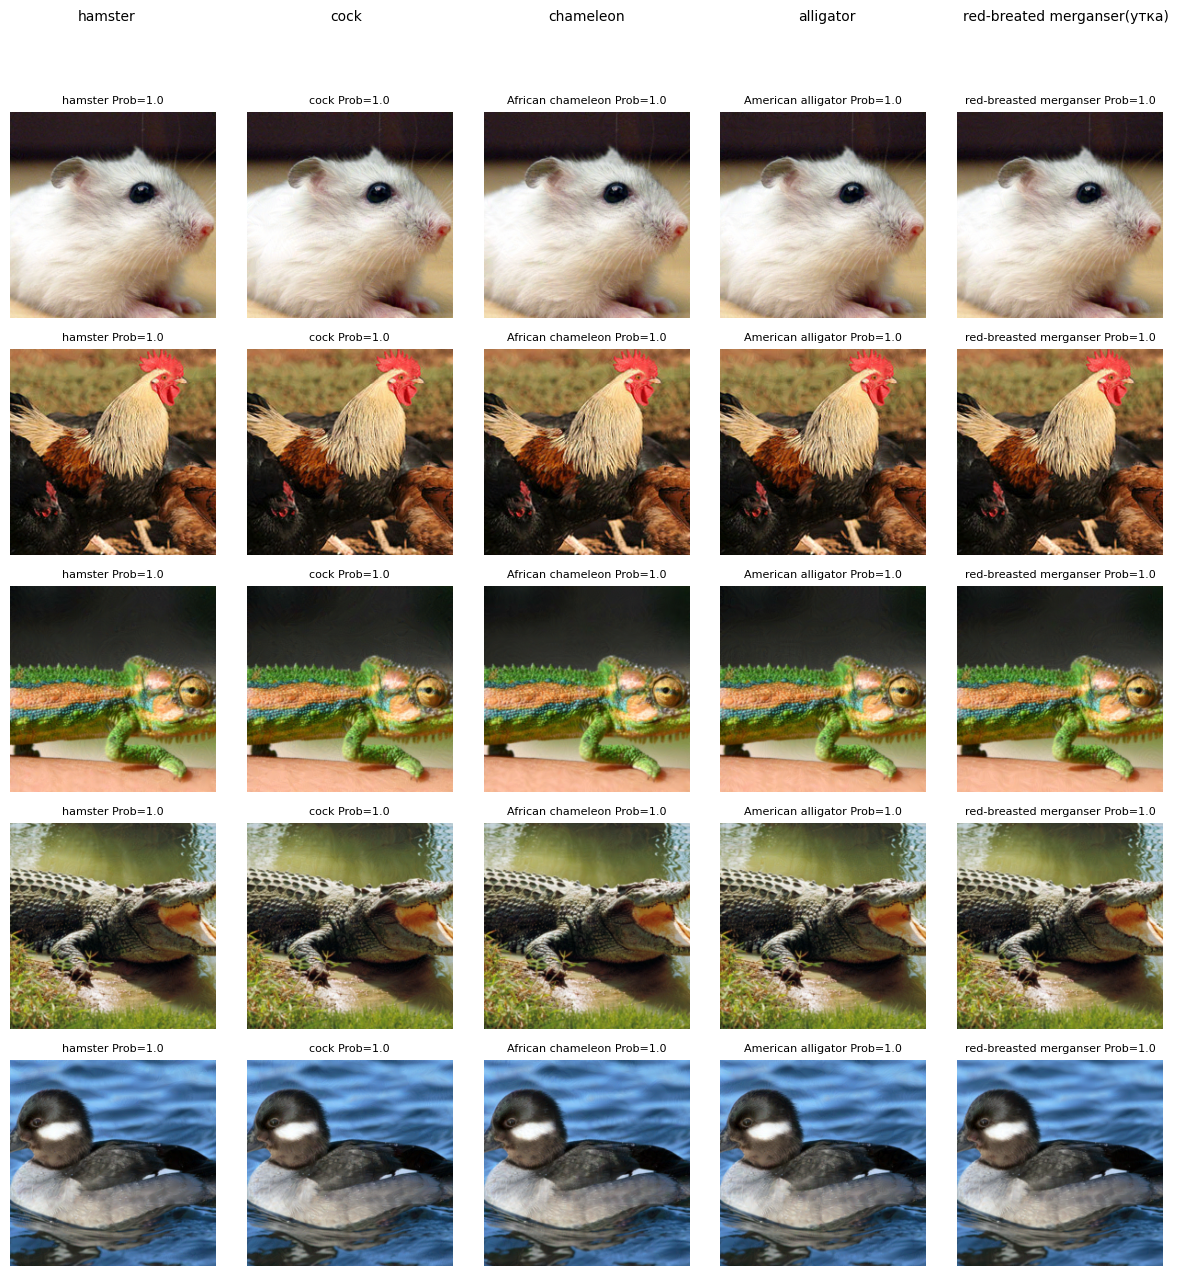

In [ ]:
import matplotlib.pyplot as plt

attack_images_to_show = [[] for i in range(len(attack_images))]
for i in range(len(attack_images)):
    for j in range(len(attack_images[i])):
        attack_images_to_show[i].append(np.moveaxis(postprocess(attack_images[i][j]).cpu().detach().numpy(),1,-1)[0])

# Создаем новую фигуру для отображения
plt.figure(figsize=(10, 10))
fig = plt.figure(figsize=(12, 12))

# Отображаем изображения в виде матрицы 5x5
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(attack_images_to_show[i // 5][i % 5])
    plt.title(model_outputs_after_attack[i // 5][i % 5], fontsize=8)
    plt.axis("off")


columns_labels = ['hamster', 'cock', 'chameleon', 'alligator', 'red-breated merganser(утка)']
for i, label in enumerate(columns_labels):
    fig.text(0.1 + i * 0.2, 1.05, label, ha='center')

plt.tight_layout()
plt.show()